In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain, combinations

pd.options.display.max_rows = 4000
sns.set_theme()
sns.set_palette('deep')

## Initial exploration of vitals_labs_mean table 

In [53]:
DATA_PATH = "../MIMIC-III/precomputed/all_hourly_data.h5"


In [54]:
data_full = pd.read_hdf(DATA_PATH, 'vitals_labs_mean')


In [55]:
data_full.head()

LEVEL2                                 alanine aminotransferase albumin  \
Aggregation Function                                       mean    mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                            25.0     1.8   
                              1                             NaN     NaN   
                              2                             NaN     NaN   
                              3                             NaN     NaN   
                              4                             NaN     NaN   

LEVEL2                                 albumin ascites albumin pleural  \
Aggregation Function                              mean            mean   
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0                    NaN             NaN   
                              1                    NaN             NaN   
                              2                    NaN             NaN   
                              3                    NaN             NaN   
                              4                    NaN             NaN   

LEVEL2                                 albumin urine alkaline phosphate  \
Aggregation Function                            mean               mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                  NaN               73.0   
                              1                  NaN                NaN   
                              2                  NaN                NaN   
                              3                  NaN                NaN   
                              4                  NaN                NaN   

LEVEL2                                  anion gap asparate aminotransferase  \
Aggregation Function                         mean                      mean   
subject_id hadm_id icustay_id hours_in                                        
3          145834  211552     0         20.666667                      69.0   
                              1               NaN                       NaN   
                              2               NaN                       NaN   
                              3               NaN                       NaN   
                              4               NaN                       NaN   

LEVEL2                                 basophils bicarbonate  ...  \
Aggregation Function                        mean        mean  ...   
subject_id hadm_id icustay_id hours_in                        ...   
3          145834  211552     0              NaN   16.333333  ...   
                              1              NaN         NaN  ...   
                              2              NaN         NaN  ...   
                              3              NaN         NaN  ...   
                              4              NaN         NaN  ...   

LEVEL2                                 total protein total protein urine  \
Aggregation Function                            mean                mean   
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0                  NaN                 NaN   
                              1                  NaN                 NaN   
                              2                  NaN                 NaN   
                              3                  NaN                 NaN   
                              4                  NaN                 NaN   

LEVEL2                                 troponin-i troponin-t venous pvo2  \
Aggregation Function                         mean       mean        mean   
subject_id hadm_id icustay_id hours_in                                     
3          145834  211552     0               NaN        NaN         NaN   
                              1               NaN        NaN         NaN   
                              

In [56]:
data_full.columns

MultiIndex([(    'alanine aminotransferase', 'mean'),
            (                     'albumin', 'mean'),
            (             'albumin ascites', 'mean'),
            (             'albumin pleural', 'mean'),
            (               'albumin urine', 'mean'),
            (          'alkaline phosphate', 'mean'),
            (                   'anion gap', 'mean'),
            (   'asparate aminotransferase', 'mean'),
            (                   'basophils', 'mean'),
            (                 'bicarbonate', 'mean'),
            ...
            (               'total protein', 'mean'),
            (         'total protein urine', 'mean'),
            (                  'troponin-i', 'mean'),
            (                  'troponin-t', 'mean'),
            (                 'venous pvo2', 'mean'),
            (                      'weight', 'mean'),
            (      'white blood cell count', 'mean'),
            ('white blood cell count urine', 'mean'),
            

In [57]:
colnames = set(data_full.columns.droplevel(1))
# colnames
# 104 different measurements per patient


In [58]:
ids = data_full.index.to_frame(index=False)
ids

,subject_id,hadm_id,icustay_id,hours_in
0,3,145834,211552,0
1,3,145834,211552,1
2,3,145834,211552,2
3,3,145834,211552,3
4,3,145834,211552,4
...,...,...,...,...
2200949,99999,113369,246512,22
2200950,99999,113369,246512,23
2200951,99999,113369,246512,24
2200952,99999,113369,246512,25


In [59]:
# How many different patients? -->subject, hadm, icustay id each 34472 unique patients --> can drop all but one
print(ids.icustay_id.nunique())

# patients stayed between 0 and 239h
print(ids.hours_in.max())
print(ids.hours_in.min())

34472
239
0


In [60]:
data_full.index = data_full.index.droplevel(['hadm_id', 'icustay_id'])
data_full.columns = data_full.columns.droplevel('Aggregation Function')

### TODO
- ~~how many hours for each patient maybe visualize?~~
- ~~per patient (subject_id) sum up non NaN vals in each col (or Nan instead?)~~
- ~~check if any have no Nans in the relevant features~~
- ~~maybe heatmap of patients x missing rate --> should see "good" features?~~
- ~~check patients table for additional constant features such as gender, age, ethnicity, etc ~~

### how many hours per patient?

,hours_in
count,34472.000000
mean,63.847586
std,47.591847
min,13.000000
25%,29.000000
50%,48.000000
75%,80.000000
max,240.000000


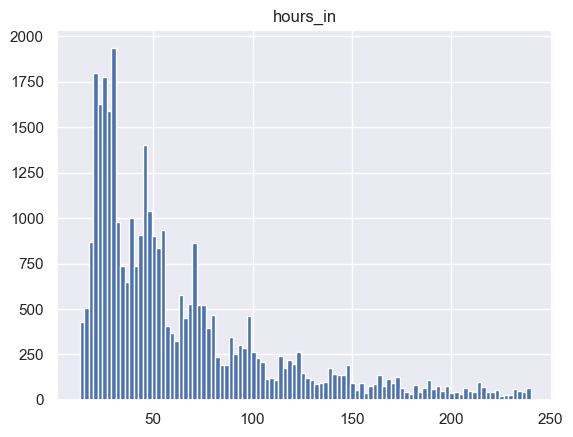

In [61]:
# How many hourly measurements per patient?
max_hours = data_full.index.to_frame(index=False).groupby('subject_id').count()
hours_histogram = max_hours.hist(bins=100)
max_hours.describe()

### Missing rate per patient

In [62]:
# How many measurements are missing per patient?
missingrates = data_full.groupby('subject_id').count()
missingrates['hours'] = max_hours

In [63]:
# Convert to percentage of missing measurements per patient
missingrates.loc[:] = missingrates[:].apply(lambda x: 1 -(x / missingrates['hours']))

C:\Users\victo\AppData\Local\Temp\ipykernel_8864\1583257888.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  missingrates.loc[:] = missingrates[:].apply(lambda x: 1 -(x / missingrates['hours']))


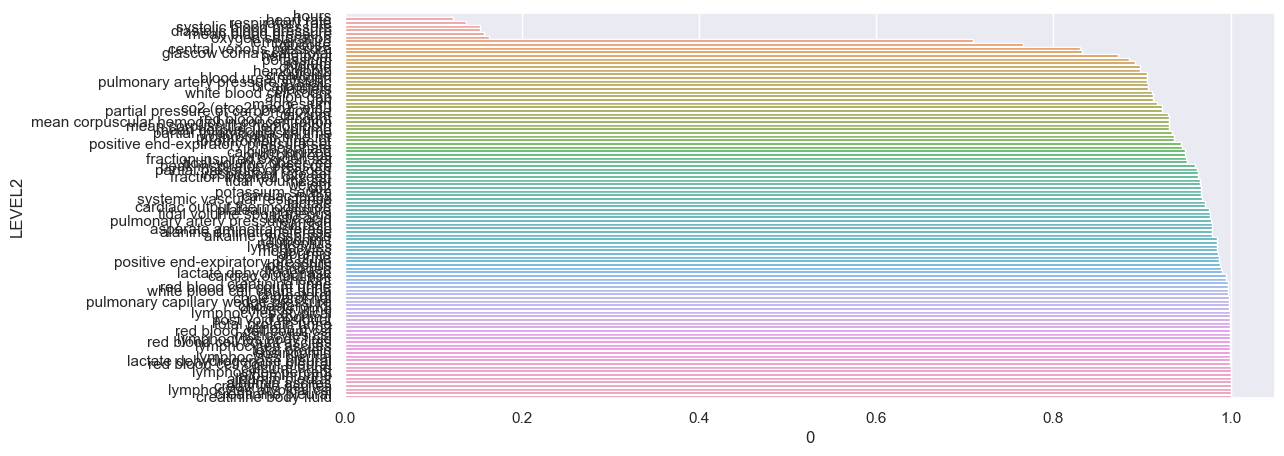

In [64]:
# barplot of missing rates by feature
fig = plt.figure(figsize=(12, 5))

sns.barplot(data=missingrates.mean().reset_index().sort_values(by=0), x=0, y="LEVEL2")
plt.show()

In [65]:
# many have almost 100% missing measurements --> drop everything above 90%
missingrates = missingrates.drop('hours', axis=1, errors='ignore')
missratesall = pd.DataFrame(missingrates.copy().mean())
missratesall.columns = ['1h']


dropcols = missingrates.columns[missingrates.mean() >= 0.90] # all cols with missing rate > 90%
missingrates = missingrates.drop(columns=dropcols)


In [66]:
# what are the 10 best features?
missingrates.mean().sort_values().round(3).head(15)

LEVEL2
heart rate                  0.122
respiratory rate            0.137
systolic blood pressure     0.152
diastolic blood pressure    0.152
mean blood pressure         0.157
oxygen saturation           0.163
temperature                 0.709
glucose                     0.766
central venous pressure     0.830
glascow coma scale total    0.833
hematocrit                  0.873
potassium                   0.886
sodium                      0.892
chloride                    0.897
hemoglobin                  0.898
dtype: float64

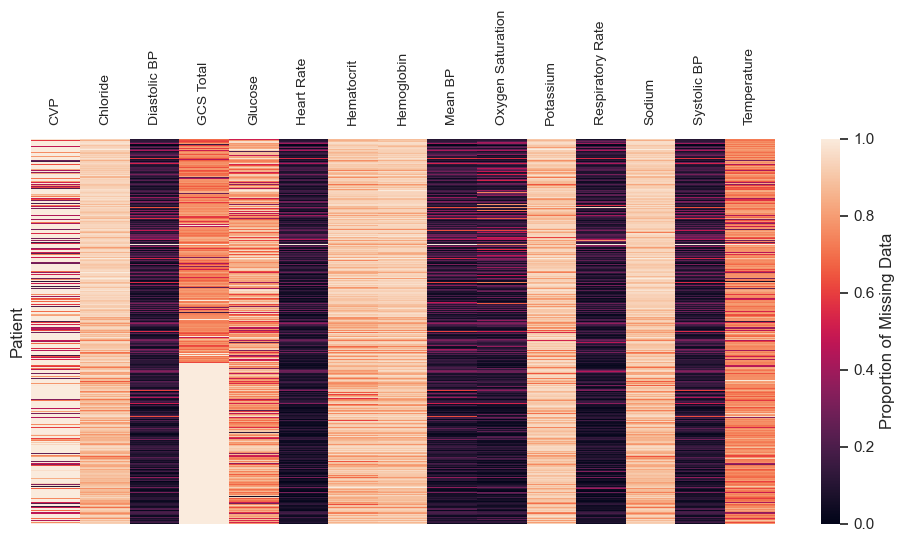

In [67]:
plt.figure(figsize=(12,5))

feats = [
    'CVP', 'Chloride', 'Diastolic BP', 'GCS Total', 'Glucose', 'Heart Rate', 'Hematocrit',
    'Hemoglobin', 'Mean BP', 'Oxygen Saturation', 'Potassium', 'Respiratory Rate', 'Sodium', 'Systolic BP', 'Temperature']
p = sns.heatmap(missingrates, xticklabels=True, yticklabels=False, cmap='rocket', cbar_kws={'label': 'Proportion of Missing Data'}, rasterized=True)

p.set_xlabel('')
p.set_ylabel('Patient')
p.set_xticklabels(feats, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

plt.savefig('outdata/images/heatmap_missingnessvitals_rasterplot.pdf', bbox_inches='tight')  
plt.show()

#### 10 Best features
noticeable bumps in missing rate after the best 6 and 10 (no 11 has ~87%)

| Measurement | Missing rate |
|--|--|
| **6 Good features**                    |
| heart rate                  | 0.121564 |
| respiratory rate            | 0.136709 |
| systolic blood pressure     | 0.152117 |
| diastolic blood pressure    | 0.152342 |
| mean blood pressure         | 0.156587 |
| oxygen saturation           | 0.162672 |
| **Also potentially usable**            |
| temperature                 | 0.708981 |
| glucose                     | 0.765668 |
| central venous pressure     | 0.829560 |
| glascow coma scale total    | 0.832531 |

six features are good (even though 3/6 are blood pressure :S)
some others are also potentially workable --> see if some patients have no missings in those

### test only best features
- how many patients remain (out of 34472) if we dont allow any missings in the 6 best features?

In [68]:
missingratestopsix = missingrates.drop(columns = missingrates.columns[missingrates.mean() >= 0.50]) # only keep top 6

# count missing rate of 0 
missingratestopsix[missingratestopsix == 0].count()

LEVEL2
diastolic blood pressure    264
heart rate                  480
mean blood pressure         260
oxygen saturation           377
respiratory rate            450
systolic blood pressure     267
dtype: int64

In [69]:
# only very few patients have features w/ no missing values --> any with no missing over all features? 
missingratestopsix.loc[(missingratestopsix==0).all(axis=1)].shape

# 160 patients have no missing values over all 6 best features --> probably not enough for training?

(160, 6)

In [70]:
missingratestopsix

LEVEL2,diastolic blood pressure,heart rate,mean blood pressure,oxygen saturation,respiratory rate,systolic blood pressure
subject_id,,,,,,
3,0.075342,0.054795,0.075342,0.054795,0.054795,0.068493
4,0.365854,0.268293,0.365854,0.268293,0.560976,0.365854
6,0.078652,0.044944,0.078652,0.067416,0.056180,0.078652
9,0.062500,0.062500,0.070312,0.062500,0.062500,0.062500
11,0.128205,0.153846,0.153846,0.256410,0.230769,0.128205
...,...,...,...,...,...,...
99983,0.200000,0.000000,0.200000,0.040000,0.040000,0.200000
99991,0.052632,0.026316,0.065789,0.026316,0.039474,0.052632
99992,0.166667,0.083333,0.145833,0.083333,0.083333,0.166667


## Reduce Sampling Rate
- only collect samples every 6,12,24 hours --> average values within this time 


In [71]:
data_full.shape

(2200954, 104)

In [72]:
# create labels for new time steps
data_full['2h'] = data_full.groupby(['subject_id']).cumcount()//2
data_full['4h'] = data_full.groupby(['subject_id']).cumcount()//4
data_full['6h'] = data_full.groupby(['subject_id']).cumcount()//6
data_full['12h'] = data_full.groupby(['subject_id']).cumcount()//12
data_full['24h'] = data_full.groupby(['subject_id']).cumcount()//24

data_full.shape

(2200954, 109)

### 6h sampling rate

In [73]:
# create new dataframe for 6h sampling rate
sampling6h_df = data_full.drop(columns=['2h', '4h', '12h', '24h']).groupby(['subject_id', '6h']).mean() # group 6h together and take mean

# count all 6h timesteps per patient
timesteps6h = sampling6h_df.index.to_frame(index=False).groupby('subject_id').count()

# calculate missing rate per patient when sampling every 6h
missrates6h = sampling6h_df.groupby('subject_id').count() # count all measurements
missrates6h['timestep'] = timesteps6h
missrates6h.loc[:] = missrates6h[:].apply(lambda x: 1 -(x / missrates6h['timestep'])) # divide number of timesteps by number of measurements --> missing rate
missrates6h = missrates6h.drop('timestep', axis=1)



C:\Users\victo\AppData\Local\Temp\ipykernel_8864\205811703.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  missrates6h.loc[:] = missrates6h[:].apply(lambda x: 1 -(x / missrates6h['timestep'])) # divide number of timesteps by number of measurements --> missing rate


In [74]:
# Check top 10 features again
print(missrates6h.mean().sort_values().head(15))



# save columns to list in order of missing rate (best to worst)
sortedfeats6h = missrates6h.mean().sort_values().index.to_list()
missratesall['6h'] = missrates6h.mean()


LEVEL2
heart rate                  0.055274
systolic blood pressure     0.059074
diastolic blood pressure    0.059156
mean blood pressure         0.061970
respiratory rate            0.062924
oxygen saturation           0.067570
temperature                 0.138968
glucose                     0.318922
glascow coma scale total    0.505922
hematocrit                  0.535808
potassium                   0.536738
sodium                      0.588124
chloride                    0.600406
creatinine                  0.609682
blood urea nitrogen         0.611035
dtype: float64


In [75]:
# drop all columns with more than 90% missing values
dropcols = missrates6h.columns[missrates6h.mean() >= 0.60] # all cols with missing rate > 60%
missrates6h = missrates6h.drop(columns=dropcols)

print(f"How many features remain after dropping columns with more than 60% missing values? {missrates6h.shape[1]}")

How many features remain after dropping columns with more than 60% missing values? 12


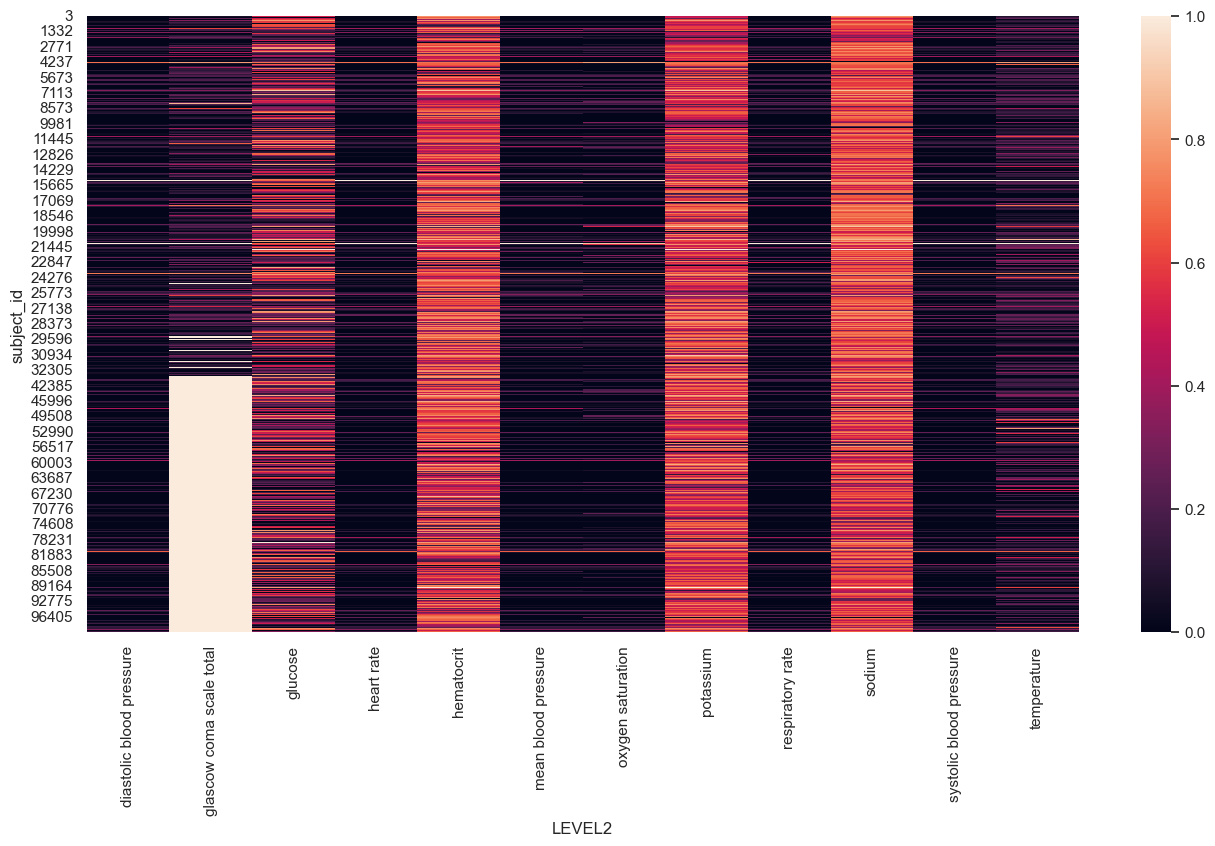

In [76]:
plt.figure(figsize=(16,8))
p = sns.heatmap(missrates6h, xticklabels=True)

plt.show()

#### Check how many patients are available for different combinations of features
- 6 features have very low missing rates --> always use those (maybe drop mean blood pressure?)
- 6 other features missing rates <60
- 2^6 = 64 subsets of features --> maybe check all of them

In [77]:
# powerset function to create all possible combinations of features

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [78]:
# create all possible combinations of the other features
otherfeats_6h = [list(l) for l in powerset(sortedfeats6h[6:])]

# add best 6 features to each combination
combos_6h = [sortedfeats6h[:6] + l for l in otherfeats_6h]

# count all rows in missrates6h where all of the selected columns have a missing rate of 0
# missrates6h.loc[(missrates6h[combos_6h[0]] == 0).all(axis=1)].shape[0]

possibleN_6h = pd.DataFrame({
    'Features' : combos_6h,
    'No Features' : [len(c) for c in combos_6h],
    'N 6h' : [missrates6h.loc[(missrates6h[c] == 0).all(axis=1)].shape[0] for c in combos_6h]
    })

possibleN_6h[possibleN_6h['N 6h'] >= 1000].sort_values(by=['No Features', 'N 6h'], ascending=False).to_csv('outdata/possibleN_6h.csv', sep=';')
possibleN_6h[possibleN_6h['N 6h'] >= 1000].sort_values(by=['No Features', 'N 6h'], ascending=False).head(10)


KeyboardInterrupt: 

### 12h sampling rate

In [79]:
# create new dataframe for 12h sampling rate
sampling12h_df = data_full.drop(columns=['2h', '4h', '6h', '24h']).groupby(['subject_id', '12h']).mean() # group 12h together and take mean

# count all 12h timesteps per patient
timesteps12h = sampling12h_df.index.to_frame(index=False).groupby('subject_id').count()

# calculate missing rate per patient when sampling every 12h
missrates12h = sampling12h_df.groupby('subject_id').count() # count all measurements
missrates12h['timestep'] = timesteps12h
missrates12h.loc[:] = missrates12h[:].apply(lambda x: 1 -(x / missrates12h['timestep'])) # divide number of timesteps by number of measurements --> missing rate
missrates12h = missrates12h.drop('timestep', axis=1)



C:\Users\victo\AppData\Local\Temp\ipykernel_8864\2497676921.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  missrates12h.loc[:] = missrates12h[:].apply(lambda x: 1 -(x / missrates12h['timestep'])) # divide number of timesteps by number of measurements --> missing rate


In [80]:
# Check top 15 features
print(missrates12h.mean().sort_values().head(104))

# save columns to list in order of missing rate (best to worst)
sortedfeats12h = missrates12h.mean().sort_values().index.to_list()
missratesall['12h'] = missrates12h.mean()

LEVEL2
heart rate                                   0.046932
systolic blood pressure                      0.050124
diastolic blood pressure                     0.050188
mean blood pressure                          0.051752
respiratory rate                             0.052618
oxygen saturation                            0.054984
temperature                                  0.101729
glucose                                      0.205622
potassium                                    0.351254
hematocrit                                   0.358634
sodium                                       0.389000
chloride                                     0.402105
creatinine                                   0.405108
blood urea nitrogen                          0.406540
bicarbonate                                  0.413870
hemoglobin                                   0.418966
platelets                                    0.428734
white blood cell count                       0.440946
anion gap            

In [81]:

# drop all columns with more than 90% missing values
dropcols = missrates12h.columns[missrates12h.mean() >= 0.60] # all cols with missing rate > 60%
missrates12h = missrates12h.drop(columns=dropcols)

print(f"How many features remain after dropping columns with more than 60% missing values? {missrates12h.shape[1]}")

How many features remain after dropping columns with more than 60% missing values? 31


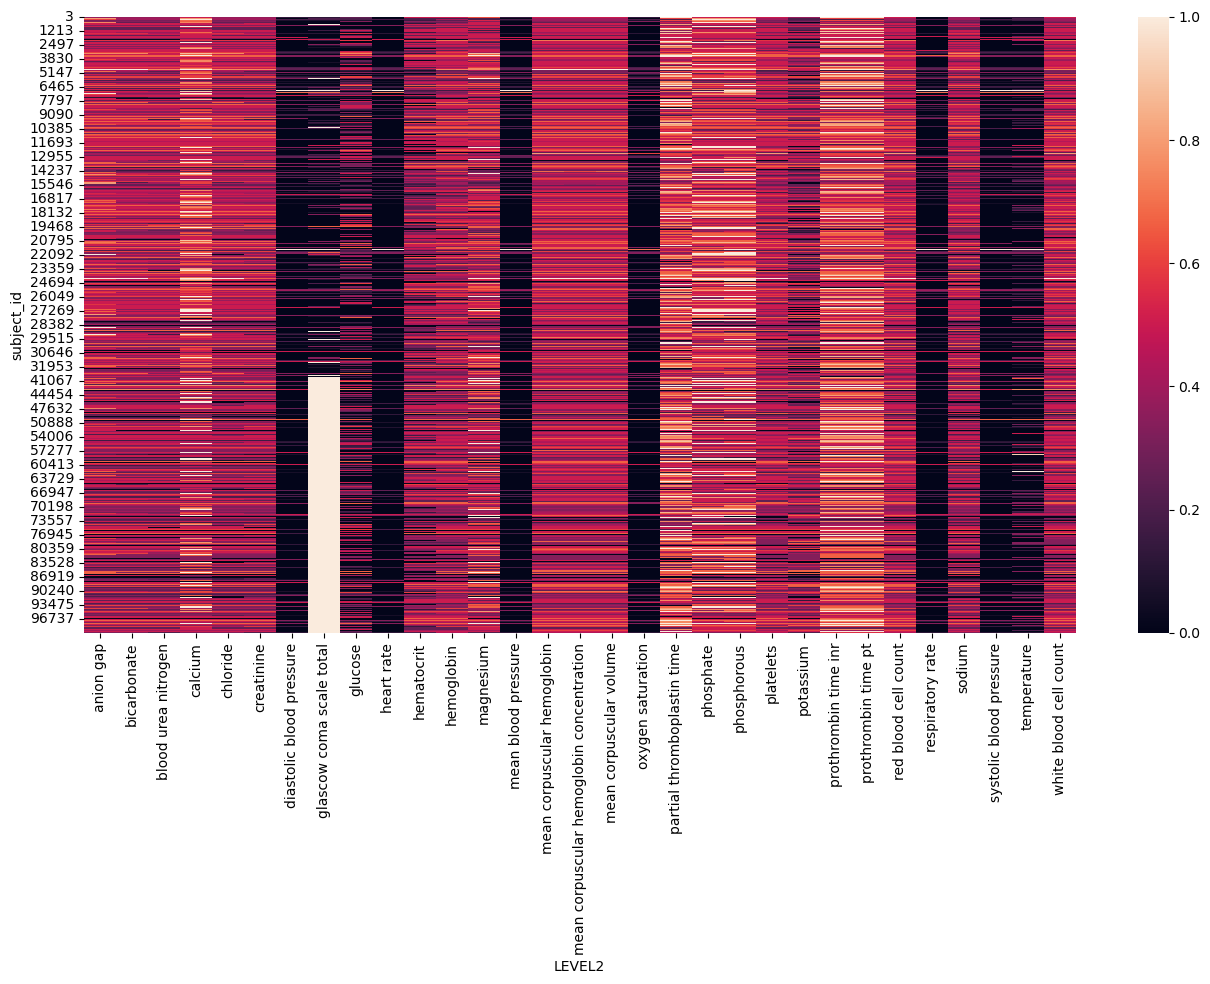

In [ ]:
plt.figure(figsize=(16,8))
p = sns.heatmap(missrates12h, xticklabels=True)

plt.show()

In order to do the thorough analysis only use the top 15 features (best 6 + 9 more)

In [ ]:
# create all possible combinations of the other features
otherfeats_12h = [list(l) for l in powerset(sortedfeats12h[6:])]

# add best 6 features to each combination
combos_12h = [sortedfeats12h[:6] + l for l in otherfeats_12h]

# count all rows in missrates12h where all of the selected columns have a missing rate of 0
# missrates12h.loc[(missrates12h[combos_12h[0]] == 0).all(axis=1)].shape[0]

possibleN_12h = pd.DataFrame({
    'Features' : combos_12h,
    'No Features' : [len(c) for c in combos_12h],
    'N 12h' : [missrates12h.loc[(missrates12h[c] == 0).all(axis=1)].shape[0] for c in combos_12h]
    })

possibleN_12h[possibleN_12h['N 12h'] >= 1000].sort_values(by=['No Features', 'N 12h'], ascending=False).to_csv('outdata/possibleN_12h.csv', sep=';')
possibleN_12h[possibleN_12h['N 12h'] >= 1000].sort_values(by=['No Features', 'N 12h'], ascending=False).head(15)


,Features,No Features,N 12h
3372,"[heart rate, systolic blood pressure, diastoli...",14,1287
2706,"[heart rate, systolic blood pressure, diastoli...",13,1472
3042,"[heart rate, systolic blood pressure, diastoli...",13,1409
2566,"[heart rate, systolic blood pressure, diastoli...",13,1323
2832,"[heart rate, systolic blood pressure, diastoli...",13,1308
2567,"[heart rate, systolic blood pressure, diastoli...",13,1291
2571,"[heart rate, systolic blood pressure, diastoli...",13,1290
2581,"[heart rate, systolic blood pressure, diastoli...",13,1290
2601,"[heart rate, systolic blood pressure, diastoli...",13,1287
3098,"[heart rate, systolic blood pressure, diastoli...",13,1071


Using a sampling rate of 12h and a minimum number of subjects of n=1000 allows about 12-14 features to be used.

### 2h sampling rate

In [82]:
# create new dataframe for 2h sampling rate
sampling2h_df = data_full.drop(columns=['4h', '6h', '12h', '24h']).groupby(['subject_id', '2h']).mean() # group 2h together and take mean

# count all 2h timesteps per patient
timesteps2h = sampling2h_df.index.to_frame(index=False).groupby('subject_id').count()

# calculate missing rate per patient when sampling every 2h
missrates2h = sampling2h_df.groupby('subject_id').count() # count all measurements
missrates2h['timestep'] = timesteps2h
missrates2h.loc[:] = missrates2h[:].apply(lambda x: 1 -(x / missrates2h['timestep'])) # divide number of timesteps by number of measurements --> missing rate
missrates2h = missrates2h.drop('timestep', axis=1)


C:\Users\victo\AppData\Local\Temp\ipykernel_8864\3462994740.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  missrates2h.loc[:] = missrates2h[:].apply(lambda x: 1 -(x / missrates2h['timestep'])) # divide number of timesteps by number of measurements --> missing rate


In [83]:
# Check top 10 features again
print(missrates2h.mean().sort_values().head(104))

# save columns to list in order of missing rate (best to worst)
sortedfeats2h = missrates2h.mean().sort_values().index.to_list()
missratesall['2h'] = missrates2h.mean()

LEVEL2
heart rate                                   0.077881
systolic blood pressure                      0.088451
diastolic blood pressure                     0.088575
respiratory rate                             0.090178
mean blood pressure                          0.093838
oxygen saturation                            0.105176
temperature                                  0.509273
glucose                                      0.630948
glascow coma scale total                     0.700434
hematocrit                                   0.787091
potassium                                    0.795836
central venous pressure                      0.814879
sodium                                       0.817822
chloride                                     0.826122
hemoglobin                                   0.829072
creatinine                                   0.835952
blood urea nitrogen                          0.836574
bicarbonate                                  0.838526
platelets            

In [84]:
# drop all columns with more than 75% missing values
dropcols = missrates2h.columns[missrates2h.mean() >= 0.75] # all cols with missing rate > 60%
missrates2h = missrates2h.drop(columns=dropcols)

print(f"How many features remain after dropping columns with more than 60% missing values? {missrates2h.shape[1]}")

How many features remain after dropping columns with more than 60% missing values? 9


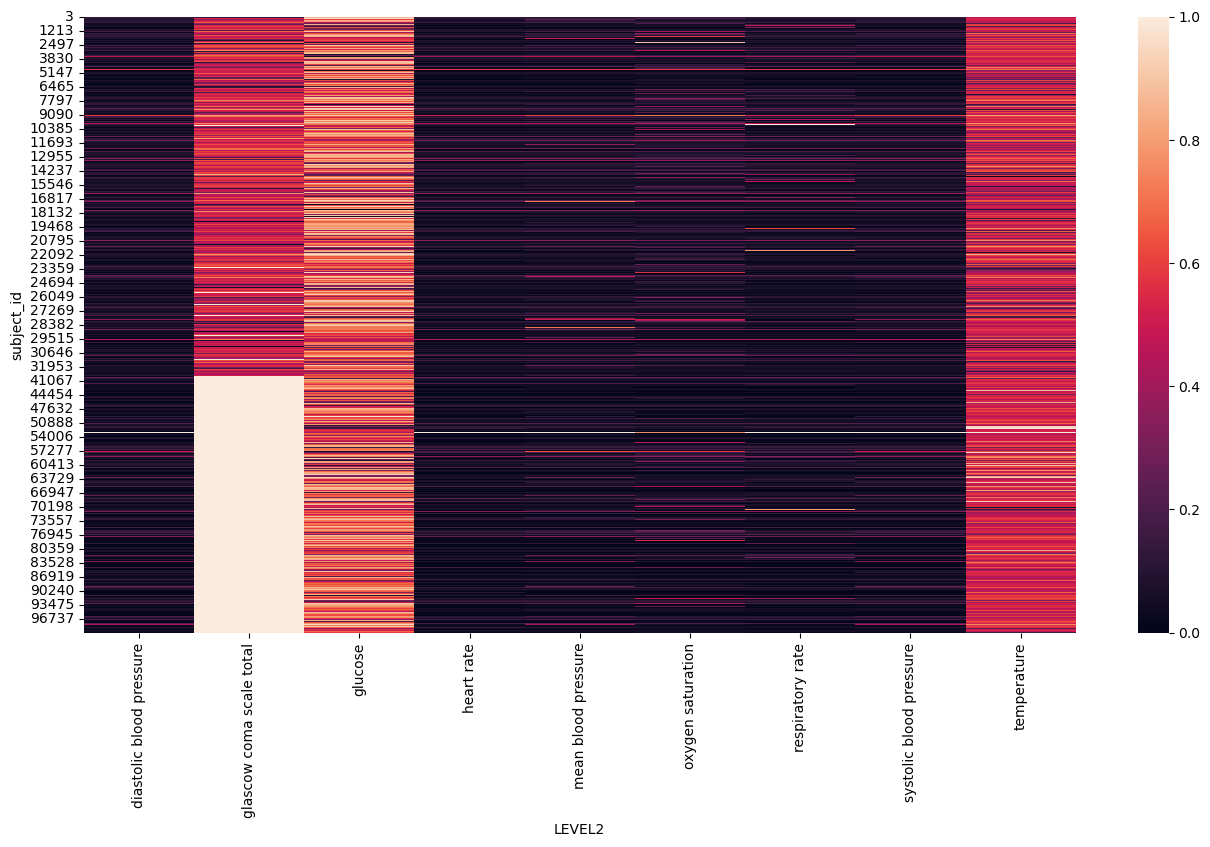

In [ ]:
plt.figure(figsize=(16,8))
p = sns.heatmap(missrates2h, xticklabels=True)

plt.show()

In [ ]:
# create all possible combinations of the other features
otherfeats_2h = [list(l) for l in powerset(sortedfeats2h[6:])]

# add best 6 features to each combination
combos_2h = [sortedfeats2h[:6] + l for l in otherfeats_2h]

# count all rows in missrates2h where all of the selected columns have a missing rate of 0
# missrates2h.loc[(missrates2h[combos_2h[0]] == 0).all(axis=1)].shape[0]

possibleN_2h = pd.DataFrame({
    'Features' : combos_2h,
    'No Features' : [len(c) for c in combos_2h],
    'N 2h' : [missrates2h.loc[(missrates2h[c] == 0).all(axis=1)].shape[0] for c in combos_2h]
    })

possibleN_2h[possibleN_2h['N 2h'] >= 1000].sort_values(by=['No Features', 'N 2h'], ascending=False).to_csv('outdata/possibleN_2h.csv', sep=';')
possibleN_2h[possibleN_2h['N 2h'] >= 1000].sort_values(by=['No Features', 'N 2h'], ascending=False).head(10)

,Features,No Features,N 2h
0,"[heart rate, systolic blood pressure, diastoli...",6,3353


### 4h sampling rate

In [85]:
# create new dataframe for 4h sampling rate
sampling4h_df = data_full.drop(columns=['2h', '6h', '12h', '24h']).groupby(['subject_id', '4h']).mean() # group 4h together and take mean

# count all 4h timesteps per patient
timesteps4h = sampling4h_df.index.to_frame(index=False).groupby('subject_id').count()

# calculate missing rate per patient when sampling every 4h
missrates4h = sampling4h_df.groupby('subject_id').count() # count all measurements
missrates4h['timestep'] = timesteps4h
missrates4h.loc[:] = missrates4h[:].apply(lambda x: 1 -(x / missrates4h['timestep'])) # divide number of timesteps by number of measurements --> missing rate
missrates4h = missrates4h.drop('timestep', axis=1)



C:\Users\victo\AppData\Local\Temp\ipykernel_8864\355232131.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  missrates4h.loc[:] = missrates4h[:].apply(lambda x: 1 -(x / missrates4h['timestep'])) # divide number of timesteps by number of measurements --> missing rate


In [86]:
# Check top 10 features again
print(missrates4h.mean().sort_values().head(104))

# save columns to list in order of missing rate (best to worst)
sortedfeats4h = missrates4h.mean().sort_values().index.to_list()
missratesall['4h'] = missrates4h.mean()


LEVEL2
heart rate                                   0.060661
systolic blood pressure                      0.065249
diastolic blood pressure                     0.065353
mean blood pressure                          0.069084
respiratory rate                             0.069605
oxygen saturation                            0.076555
temperature                                  0.195017
glucose                                      0.440789
glascow coma scale total                     0.530328
hematocrit                                   0.641726
potassium                                    0.647425
sodium                                       0.690604
chloride                                     0.701504
hemoglobin                                   0.709358
creatinine                                   0.711890
blood urea nitrogen                          0.712958
bicarbonate                                  0.716566
platelets                                    0.723000
anion gap            

In [87]:
# drop all columns with more than 90% missing values
dropcols = missrates4h.columns[missrates4h.mean() >= 0.60] # all cols with missing rate > 60%
missrates4h = missrates4h.drop(columns=dropcols)

print(f"How many features remain after dropping columns with more than 60% missing values? {missrates4h.shape[1]}")


How many features remain after dropping columns with more than 60% missing values? 9


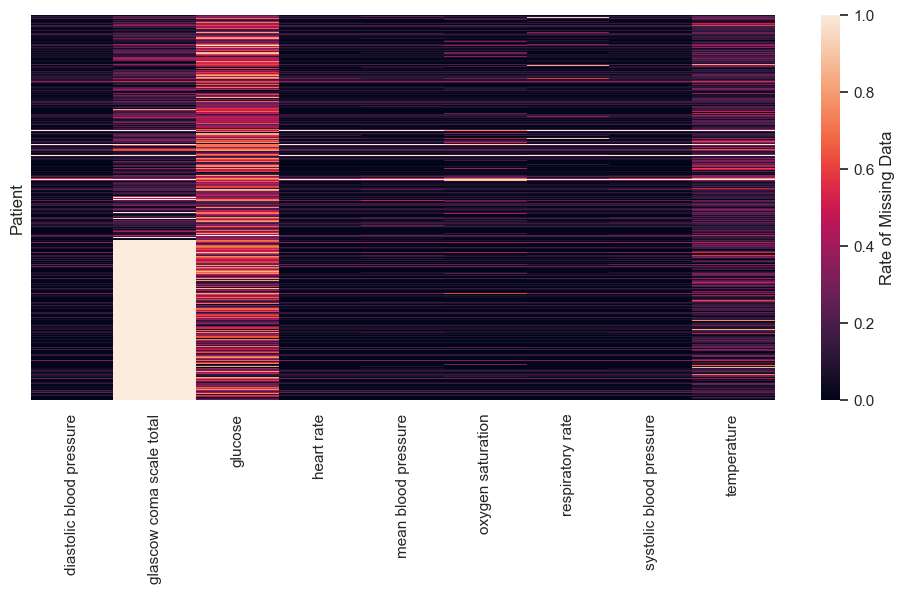

In [88]:
plt.figure(figsize=(12,5))
p = sns.heatmap(missrates4h, xticklabels=True, yticklabels=False, cmap='rocket', cbar_kws={'label': 'Rate of Missing Data'})

p.set_xlabel('')
p.set_ylabel('Patient')

plt.show()

In [ ]:
# create all possible combinations of the other features
otherfeats_4h = [list(l) for l in powerset(sortedfeats4h[6:])]

# add best 6 features to each combination
combos_4h = [sortedfeats4h[:6] + l for l in otherfeats_4h]

# count all rows in missrates4h where all of the selected columns have a missing rate of 0
# missrates4h.loc[(missrates4h[combos_4h[0]] == 0).all(axis=1)].shape[0]

possibleN_4h = pd.DataFrame({
    'Features' : combos_4h,
    'No Features' : [len(c) for c in combos_4h],
    'N 4h' : [missrates4h.loc[(missrates4h[c] == 0).all(axis=1)].shape[0] for c in combos_4h]
    })

possibleN_4h[possibleN_4h['N 4h'] >= 1000].sort_values(by=['No Features', 'N 4h'], ascending=False).to_csv('outdata/possibleN_4h.csv', sep=';')
possibleN_4h[possibleN_4h['N 4h'] >= 1000].sort_values(by=['No Features', 'N 4h'], ascending=False).head(10)


,Features,No Features,N 4h
1,"[heart rate, systolic blood pressure, diastoli...",7,2810
3,"[heart rate, systolic blood pressure, diastoli...",7,1632
0,"[heart rate, systolic blood pressure, diastoli...",6,13079


In [89]:
# missratesall.sort_values(by='1h').round(3).head(10)
missingratesout = missratesall[['1h', '2h', '4h', '6h', '12h']].sort_values(by='1h').round(3)
missingratesout.head(10)

,1h,2h,4h,6h,12h
LEVEL2,,,,,
heart rate,0.122,0.078,0.061,0.055,0.047
respiratory rate,0.137,0.090,0.070,0.063,0.053
systolic blood pressure,0.152,0.088,0.065,0.059,0.050
diastolic blood pressure,0.152,0.089,0.065,0.059,0.050
mean blood pressure,0.157,0.094,0.069,0.062,0.052
oxygen saturation,0.163,0.105,0.077,0.068,0.055
temperature,0.709,0.509,0.195,0.139,0.102
glucose,0.766,0.631,0.441,0.319,0.206
central venous pressure,0.830,0.815,0.800,0.792,0.782


### Tradeoff between sampling rate and number of timepoints per patient

Check average number of timepoints per patient for the different sampling rates given the maximum possible number of features and n>=1000

In [ ]:
# save the best combinations of features for 6h and 12h sampling rate
bestcombo2h = possibleN_2h[possibleN_2h['N 2h'] >= 1000].sort_values(by=['No Features', 'N 2h'], ascending=False).head(1)['Features'].values[0]
bestcombo4h = possibleN_4h[possibleN_4h['N 4h'] >= 1000].sort_values(by=['No Features', 'N 4h'], ascending=False).head(1)['Features'].values[0]
bestcombo6h = possibleN_6h[possibleN_6h['N 6h'] >= 1000].sort_values(by=['No Features', 'N 6h'], ascending=False).head(1)['Features'].values[0]
bestcombo12h = possibleN_12h[possibleN_12h['N 12h'] >= 1000].sort_values(by=['No Features', 'N 12h'], ascending=False).head(1)['Features'].values[0]

# find the corresponding patient ids
patids2h = missrates2h.loc[(missrates2h[bestcombo2h] == 0).all(axis=1)].index.to_list()
patids4h = missrates4h.loc[(missrates4h[bestcombo4h] == 0).all(axis=1)].index.to_list()
patids6h = missrates6h.loc[(missrates6h[bestcombo6h] == 0).all(axis=1)].index.to_list()
patids12h = missrates12h.loc[(missrates12h[bestcombo12h] == 0).all(axis=1)].index.to_list()


NameError: name 'possibleN_2h' is not defined

In [90]:
# select the patients from the timesteps tables and average the number of steps
timesteps = pd.DataFrame(
    data = {'2h' : timesteps2h.loc[patids2h].describe()['2h'],
            '4h' : timesteps4h.loc[patids4h].describe()['4h'],    
            '6h' : timesteps6h.loc[patids6h].describe()['6h'],
            '12h' : timesteps12h.loc[patids12h].describe()['12h']},
    index= ['count', 'mean', 'std', 'min', 'max']).T

timesteps.rename(columns={'count':'n', 'mean' : 'mean_steps', 'std' : 'std_steps', 'min' : 'min_steps', 'max' : 'max_steps'}, inplace=True)
timesteps.insert(1, 'num_feats', [6,7,8,14])

timesteps.round(1)

NameError: name 'patids2h' is not defined

<AxesSubplot: xlabel='num_feats', ylabel='mean_steps'>

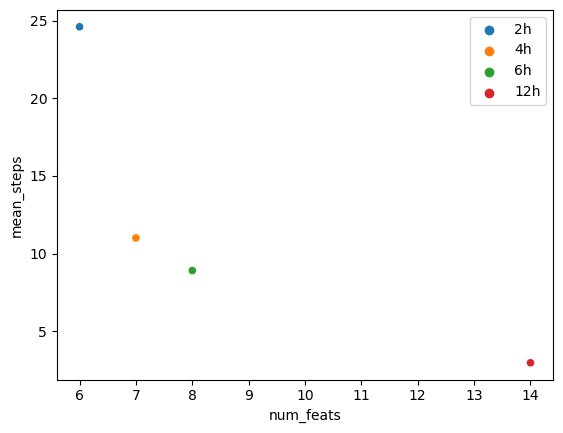

In [ ]:
sns.scatterplot(data=timesteps, x='num_feats', y='mean_steps', hue=timesteps.index) 


In [ ]:
# numsteps = pd.DataFrame(
#     data = {'1h' : max_hours,
#             '2h' : timesteps2h,
#             '4h' : timesteps4h,
#             '6h' : timesteps6h,
#             '12h' : timesteps12h},
#     index= max_hours.index)

In [91]:
hours = pd.concat([max_hours, timesteps2h, timesteps4h, timesteps6h, timesteps12h], axis=1)
hours.columns = ['1h', '2h', '4h', '6h', '12h']

In [ ]:
hours.describe().round(1)

,1h,2h,4h,6h,12h
count,34472.0,34472.0,34472.0,34472.0,34472.0
mean,63.8,32.2,16.3,11.1,5.8
std,47.6,23.8,11.9,7.9,4.0
min,13.0,7.0,4.0,3.0,2.0
25%,29.0,15.0,8.0,5.0,3.0
50%,48.0,24.0,12.0,8.0,4.0
75%,80.0,40.0,20.0,14.0,7.0
max,240.0,120.0,60.0,40.0,20.0


In [92]:
test =hours.reset_index().melt(id_vars='subject_id', var_name='sampling_rate', value_name='timesteps')

In [93]:
test.groupby('subject_id').count()

,sampling_rate,timesteps
subject_id,,
3,5,5
4,5,5
6,5,5
9,5,5
11,5,5
...,...,...
99983,5,5
99991,5,5
99992,5,5


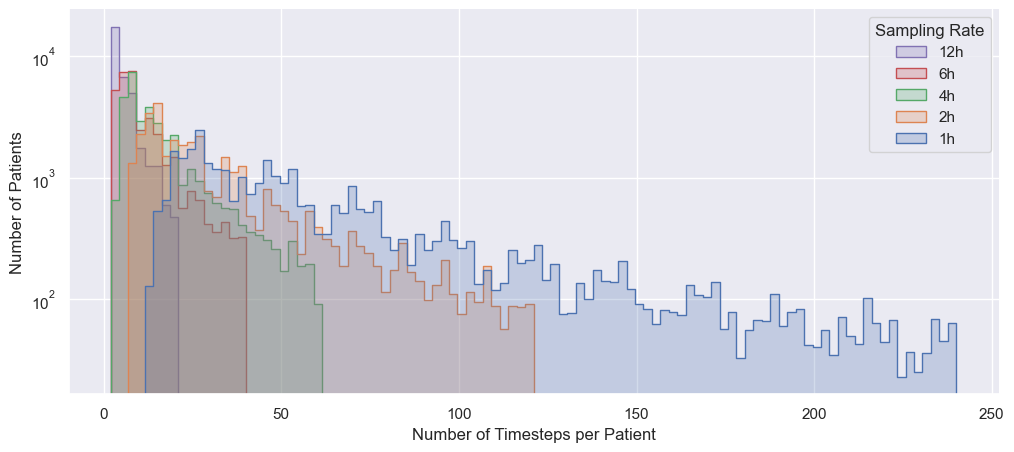

In [95]:
fig = plt.figure(figsize=(12,5))
# histogram of the number of hours each patient has data for
p = sns.histplot(data=test, bins=100, x="timesteps", hue="sampling_rate", element='step', log_scale=(False,True))

p.set_xlabel('Number of Timesteps per Patient')
p.set_ylabel('Number of Patients')

# despine
sns.despine()
plt.legend(title='Sampling Rate', loc='upper right', labels=['12h', '6h', '4h', '2h', '1h'])


plt.savefig('outdata/images/histo_numtimesteps.pdf', bbox_inches='tight')  
plt.show()